# parameter tuned
reference : https://www.kaggle.com/znyksh/fork-lightgbm-with-simple-features/versions#base=4143658&new=4153250

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import time
import gc
from tqdm import tqdm

In [2]:
!ls

aguiar's_kernel.ipynb
data_visualize.ipynb
feature_matrix.csv
feature_selection-feature_by_kageyama-25CV-parameter-by-Ivan_noIDs.ipynb
feature_selection-feature_by_olivier-25CV-parameter-by-Ivan_noIDs.ipynb
feature_selection_feature_matrix_by_kageyama.ipynb
feature_selection_feature_matrix_by_olivier.ipynb
feature_selection_feature_matrix_noIDs_by_kageyama.ipynb
featuretools-for-Kageyama.ipynb
featuretools-for-aguiar.ipynb
featuretools-for-olivier.ipynb
featuretools.ipynb
kageyama-25CV_noIDs_delunimportant_90.ipynb
kageyama-25CV_noIDs_delunimportant_92.ipynb
kageyama-25CV_noIDs_delunimportant_94.ipynb
kageyama-25CV_noIDs_delunimportant_96.ipynb
kageyama-25CV_noIDs_delunimportant_98.ipynb
kageyama_feature_matrix_25cv_tuned_by_Ivan_sub_noIDs.csv
kageyama_feature_matrix_25cv_tuned_by_Ivan_sub_noIDs_delmissing_delunimportant_794.csv
kageyama_feature_matrix_90.0.csv
kageyama_feature_matrix_92.0.csv
kageyama_feature_matrix_94.0.csv
kageyama_feature_matrix_96.0.csv
kageyama_feature_matrix_98.

In [3]:
st = time.time()
df = pd.read_csv('./kageyama_feature_matrix_90.0.csv')
time.time() - st

53.852922439575195

In [4]:
df = df.drop('SK_ID_CURR', axis=1)

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_feats = [f for f in df.columns if df[f].dtype == 'object']
for col in tqdm(categorical_feats):
    if col == 'set' :
        continue
    df[col] = df[col].astype('str')
    le.fit(df[col])
    df[col] = le.transform(df[col])
train_df = df.loc[df['set'] == 'train'] .drop('set', axis = 1)
test_df = df.loc[df['set'] == 'test'] .drop(['set', 'TARGET'], axis=1)

del df
gc.collect()

100%|██████████| 13/13 [00:11<00:00,  1.10it/s]


36

In [6]:
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])

feature_importance_df = pd.DataFrame()
y = train_df['TARGET'].copy()
X = train_df.drop('TARGET', axis = 1)


feats =  list(X.columns)

folds = KFold(n_splits=25, shuffle=True, random_state=2018)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    train_X, train_y = X.iloc[trn_idx], y.iloc[trn_idx]
    valid_X, valid_y = X.iloc[val_idx], y.iloc[val_idx]

    clf = LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.02,
        num_leaves=32,
        colsample_bytree=.8,
        subsample=.87,
        max_depth=8,
        reg_alpha=.0415,
        reg_lambda=.0735,
        min_split_gain=.02,
        min_child_weight=40,
        silent=-1,
        verbose=-1,
    )

    clf.fit(train_X, train_y, 
            eval_set= [(train_X, train_y), (valid_X, valid_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
           )

    oof_preds[val_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[val_idx])))
    del clf, train_X, train_y, valid_X, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

sub = pd.read_csv('../input/sample_submission.csv')
sub['TARGET'] = sub_preds



Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.759171	valid_1's auc: 0.752189
[200]	training's auc: 0.78065	valid_1's auc: 0.76424
[300]	training's auc: 0.797961	valid_1's auc: 0.774257
[400]	training's auc: 0.80955	valid_1's auc: 0.778985
[500]	training's auc: 0.818661	valid_1's auc: 0.781432
[600]	training's auc: 0.826663	valid_1's auc: 0.783082
[700]	training's auc: 0.833812	valid_1's auc: 0.784304
[800]	training's auc: 0.840181	valid_1's auc: 0.785282
[900]	training's auc: 0.846024	valid_1's auc: 0.786047
[1000]	training's auc: 0.851808	valid_1's auc: 0.78663
[1100]	training's auc: 0.857236	valid_1's auc: 0.787051
[1200]	training's auc: 0.861994	valid_1's auc: 0.787401
[1300]	training's auc: 0.866921	valid_1's auc: 0.787681
[1400]	training's auc: 0.871629	valid_1's auc: 0.788025
[1500]	training's auc: 0.875901	valid_1's auc: 0.788294
Early stopping, best iteration is:
[1480]	training's auc: 0.874991	valid_1's auc: 0.788401
Fold  1 AUC : 0.788

[500]	training's auc: 0.818732	valid_1's auc: 0.776224
[600]	training's auc: 0.826635	valid_1's auc: 0.778022
[700]	training's auc: 0.833587	valid_1's auc: 0.779303
[800]	training's auc: 0.840172	valid_1's auc: 0.7799
[900]	training's auc: 0.846068	valid_1's auc: 0.780544
[1000]	training's auc: 0.851587	valid_1's auc: 0.781077
[1100]	training's auc: 0.856966	valid_1's auc: 0.781668
[1200]	training's auc: 0.861677	valid_1's auc: 0.782157
[1300]	training's auc: 0.866637	valid_1's auc: 0.782658
[1400]	training's auc: 0.871221	valid_1's auc: 0.783098
[1500]	training's auc: 0.875719	valid_1's auc: 0.783854
[1600]	training's auc: 0.879798	valid_1's auc: 0.784101
Early stopping, best iteration is:
[1559]	training's auc: 0.878153	valid_1's auc: 0.784227
Fold  9 AUC : 0.784227
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.759095	valid_1's auc: 0.761216
[200]	training's auc: 0.780349	valid_1's auc: 0.774599
[300]	training's auc: 0.79743	valid_1's auc: 0.7

[600]	training's auc: 0.826416	valid_1's auc: 0.794785
[700]	training's auc: 0.83352	valid_1's auc: 0.796036
[800]	training's auc: 0.840044	valid_1's auc: 0.796616
[900]	training's auc: 0.846194	valid_1's auc: 0.797229
[1000]	training's auc: 0.85181	valid_1's auc: 0.797353
[1100]	training's auc: 0.857044	valid_1's auc: 0.797602
[1200]	training's auc: 0.862056	valid_1's auc: 0.797944
[1300]	training's auc: 0.866914	valid_1's auc: 0.79804
Early stopping, best iteration is:
[1233]	training's auc: 0.863696	valid_1's auc: 0.798154
Fold 17 AUC : 0.798154
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758705	valid_1's auc: 0.759945
[200]	training's auc: 0.780122	valid_1's auc: 0.776751
[300]	training's auc: 0.79711	valid_1's auc: 0.788901
[400]	training's auc: 0.808562	valid_1's auc: 0.793793
[500]	training's auc: 0.817725	valid_1's auc: 0.796998
[600]	training's auc: 0.825914	valid_1's auc: 0.79928
[700]	training's auc: 0.833149	valid_1's auc: 0.800523

[500]	training's auc: 0.818263	valid_1's auc: 0.788726
[600]	training's auc: 0.826381	valid_1's auc: 0.791634
[700]	training's auc: 0.833366	valid_1's auc: 0.793169
[800]	training's auc: 0.839947	valid_1's auc: 0.79428
[900]	training's auc: 0.846087	valid_1's auc: 0.79495
[1000]	training's auc: 0.851679	valid_1's auc: 0.79573
[1100]	training's auc: 0.856825	valid_1's auc: 0.796377
[1200]	training's auc: 0.861877	valid_1's auc: 0.796714
[1300]	training's auc: 0.86667	valid_1's auc: 0.796943
[1400]	training's auc: 0.871125	valid_1's auc: 0.797102
[1500]	training's auc: 0.875665	valid_1's auc: 0.797447
[1600]	training's auc: 0.879942	valid_1's auc: 0.797474
Early stopping, best iteration is:
[1509]	training's auc: 0.875999	valid_1's auc: 0.79751
Fold 25 AUC : 0.797510
Full AUC score 0.793068


In [7]:
sub.to_csv('./kageyama_90_sub.csv', index=None)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

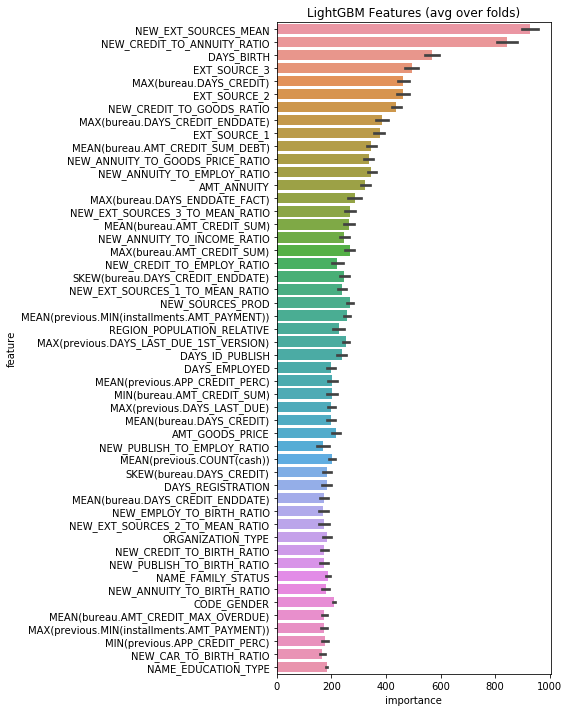

In [9]:
display_importances(feature_importance_df)

In [10]:
time.time() - st

9784.358341217041